<a href="https://colab.research.google.com/github/sdiaz8/sdiaz8/blob/main/Financial_Analytics_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install and import packages
!pip install yfinance
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns
import warnings
import yfinance as yf
import seaborn as sns; sns.set()
yf.pdr_override() 
%matplotlib inline
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


#Data Retrieval

In [ ]:
#Closing Prices for Microsoft, Meta, Advanced Micro, NVIDIA and S&P
stocks = ['MSFT','META','AMD','NVDA',]
start = datetime.datetime(2021, 1, 1)
end = datetime.datetime(2021, 12, 31)
stock_price = yf.download(stocks, start=start, end=end, interval='1d')
stock_price = stock_price['Close']
stock_price.head()

[*********************100%***********************]  4 of 4 completed


,AMD,META,MSFT,NVDA
Date,,,,
2021-01-04,92.300003,268.940002,217.690002,131.134995
2021-01-05,92.769997,270.970001,217.899994,134.047501
2021-01-06,90.330002,263.309998,212.250000,126.144997
2021-01-07,95.160004,268.739990,218.289993,133.440002
2021-01-08,94.580002,267.570007,219.619995,132.767502


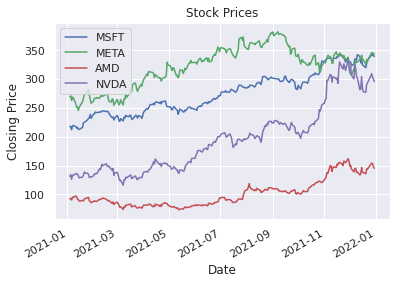

In [ ]:
stock_price.loc[:,['MSFT','META','AMD','NVDA']].plot()
plt.title('Stock Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

In [ ]:
#Correlation of Stocks
stock_price.corr()

,AMD,META,MSFT,NVDA
AMD,1.000000,0.390980,0.886497,0.941307
META,0.390980,1.000000,0.692820,0.592062
MSFT,0.886497,0.692820,1.000000,0.961991
NVDA,0.941307,0.592062,0.961991,1.000000


The stocks which are the most correlated are NVDA and MSFT as well as NVDA and AMD.

#Efficeint Frontier

In [ ]:
!pip install PyPortfolioOpt
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting, CLA

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 3.9 MB/s 


In [ ]:
mu = expected_returns.capm_return(stock_price)
S = risk_models.CovarianceShrinkage(stock_price).ledoit_wolf()
cla = CLA (mu, S)

In [ ]:
mu

AMD      0.874853
META     0.502989
MSFT     0.394285
NVDA     0.966481
^GSPC    0.255564
Name: mkt, dtype: float64

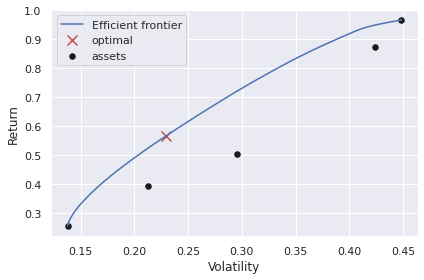

In [ ]:
ax = plotting.plot_efficient_frontier(cla)
ax

From the plot above, AMD and NVDA are the stocks that we should invest in.  Even though they are highly volatile, they have a much higher return than MSFT, META and the S&P500.  

#Preparing Stationary Data

In [ ]:
amd_diff = amd_close.diff().dropna()
amd_diff

Date
2021-01-05    0.469994
2021-01-06   -2.439995
2021-01-07    4.830002
2021-01-08   -0.580002
2021-01-11    2.669998
                ...   
2021-12-23    2.259995
2021-12-27    8.220001
2021-12-28   -1.210007
2021-12-29   -4.889999
2021-12-30   -3.110001
Name: AMD, Length: 250, dtype: float64

#Moving Average for AMD

In [ ]:
#Extracting AMD closing prices, making data stationary
amd_close = stock_price['AMD']
amd_diff = amd_close.diff().dropna()

In [ ]:
#Checking Data is Stationary
from statsmodels.tsa.stattools import adfuller
stat_test = adfuller(amd_diff)
test_stat = stat_test[0]
p_value = stat_test[1]
test_stat, p_value

(-17.109276907656934, 7.384805430367066e-30)

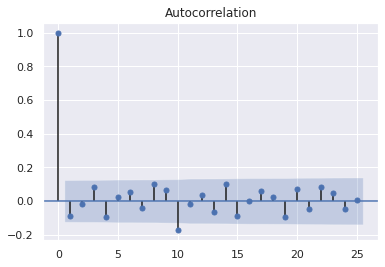

In [ ]:
#Autocorrelation for AMD
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(amd_diff, lags = 25);

In [ ]:
#Test and Training Data
train_len_amd = int(len(amd_diff) * 0.8)
train_amd = amd_diff[:train_len_amd]
test_amd = amd_diff[train_len_amd:]
start = len(train_amd)
end = len(train_amd) + len(test_amd) - 1

In [ ]:
#MA AMD Modeling
from statsmodels.tsa.arima.model import ARIMA
ma_model = ARIMA(amd_diff, order = (0 ,0, 10))
ma_result = ma_model.fit()
ma_pred = ma_result.predict(start, end)
ma_pred.index = test_amd.index

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


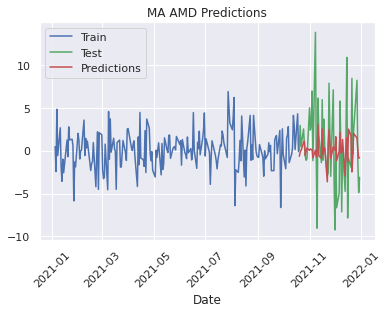

In [ ]:
#MA AMD Plot
plt.plot(train_amd.index, train_amd, label='Train')
plt.plot(test_amd.index, test_amd, label='Test')
plt.plot(ma_pred.index, ma_pred, label='Predictions')
plt.title('MA AMD Predictions')
plt.legend()
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

In [ ]:
#MA Forecast
forecast_index = pd.date_range(test_amd.index[-1], periods=10)
ma_forecast = ma_result.forecast(steps=10)
ma_forecast.index = forecast_index

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


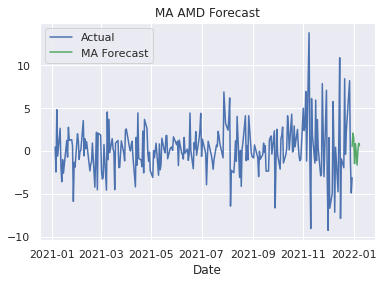

In [ ]:
#MA AMD Forecasting
plt.plot(amd_diff, label='Actual')
plt.plot(ma_forecast.index, ma_forecast, label='MA Forecast')
plt.title('MA AMD Forecast')
plt.legend()
plt.xlabel('Date')
plt.show()

In [ ]:
#RMSE for MA of AMD
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_amd = mean_absolute_error(test_amd, ma_pred)
mse_amd = mean_squared_error(test_amd, ma_pred)
rmse_amd = np.sqrt(mean_squared_error(test_amd, ma_pred))
rmse_amd

4.627589394728313

#Autoregressive Moving Average Model

In [ ]:
#ARMA Model and Predictions for AMD
arma_model = ARIMA(train_amd, order=(10, 0, 10))
arma_result = arma_model.fit()

arma_pred = arma_result.predict(start, end)
arma_pred.index = test_amd.index

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib

In [ ]:
#ARMA AMD Forecasting
arma_model = ARIMA(amd_diff, order=(10, 0, 10)).fit()
arma_forecast = arma_model.forecast(steps=10)
arma_forecast.index = forecast_index

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib

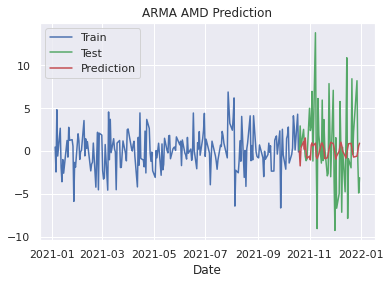

In [ ]:
#ARMA AMD Prediction Plot
plt.plot(train_amd, label='Train')
plt.plot(test_amd, label='Test')
plt.plot(arma_pred, label='Prediction')
plt.title('ARMA AMD Prediction')
plt.legend()
plt.xlabel('Date')
plt.show()

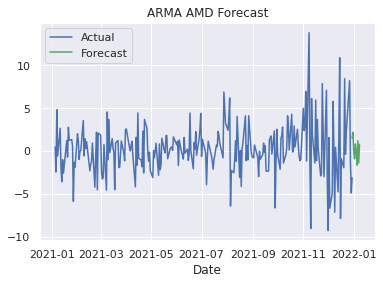

In [ ]:
#ARMA AMD Forecast
plt.plot(amd_diff, label='Actual')
plt.plot(arma_forecast, label='Forecast')
plt.title('ARMA AMD Forecast')
plt.xlabel('Date')
plt.legend()
plt.show()

In [ ]:
#RMSE for ARMA of AMD
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_amd = mean_absolute_error(test_amd, arma_pred)
mse_amd = mean_squared_error(test_amd, arma_pred)
rmse_amd = np.sqrt(mean_squared_error(test_amd, arma_pred))
rmse_amd

5.001531568927886

When comparing the Moving Average and Autoregressive Moving Average models for AMD, the best model to follow is Moving Average since the RMSE is closer to 0.